# Gaussian Processes


## Background 

Sometimes, an unknown parameter or variable in a model is not just a scalar or a vector but an entire *function*, say $f(x)$.  In a parametric model the overall form of $f(x)$ is described.  Then, the unknown parameters within the function are assigned prior distributions.  For instance, $f(x)$ may be specified as linear with unknown slope and intercept, or as a sine with unknown amplitude and frequency. 

Sometimes it's difficult to specify a good form for $f(x)$.  It could be unknown or complicated, or the function's unknown parameters may not be of interest to the wider goal of the statistical model.  A good choice for these types of scenarios is to place a Gaussian process prior over the function $f(x)$ itself.  A Gaussian process (GP) prior is a probability distribution whose support is over the space of *continuous functions*,

$$
f(x) \sim \mathcal{GP}(m(x;\,\phi), \, k(x, x';\,\theta)) \,.
$$

It is parameterized by the mean function, $m(x;\,\phi)$, and the covariance function, $k(x, x';\,\theta)$.  This description is a little abstract.  To be more concrete, consider evaluating $f(x)$ over the $x$ points represented in the finite set of data we have, and then arranging these outputs into a vector $\mathbf{f}$.  The output vector $\mathbf{f}$ is modeled as one sample from a multivariate normal distribution with mean vector $\mathbf{m}$ and covariance matrix $\mathbf{K}$.  

$$
\mathbf{f} \sim \text{N}(\mathbf{m},\, \mathbf{K}) \,.
$$

The vector $\mathbf{m}$ is the mean function evaluated at each $x$, and the covariance matrix is the result of evaluating the covariance function, or kernel, across all possible pairs of $x$ values, $(x,\, x')$.  The mean function, and especially the covariance function, determine where in the space of all continuous functions the GP prior places the most support.  The GP prior may place the most probability on functions that are periodic or quasi-period, or on functions that are very smooth or erratic and wiggly.  

## Important Properties

Gaussian processes are convenient choices for a prior over functions due to the marginalization and conditioning properties of the multivariate normal distribution.  Usually, the marginal distribution of a GP is what is evaluated during the inference step.  The conditional distribution is what is used for prediction.  Consider a two groups of points in the same domain, $x$ and $x_*$, along with say, $\mathbf{f}_x = f(x)$ and $\mathbf{f}_* = f(x_*)$.  The *joint* distribution of $\mathbf{f}_x$ and $\mathbf{f}_*$ is multivariate normal,

$$
\begin{bmatrix} \mathbf{f}_x \\ \mathbf{f}_* \\ \end{bmatrix} \sim
\text{N}\left( 
  \begin{bmatrix} \mathbf{m}_x \\ \mathbf{m}_* \\ \end{bmatrix} \,,
  \begin{bmatrix} \mathbf{K}_{xx} & \mathbf{K}_{*x} \\ \mathbf{K}_{x*} & \mathbf{K}_{**} \\ \end{bmatrix}
  \right) \,.
$$

Starting from the joint distribution, we can derive the *marginal* distribution of $\mathbf{f}_x$, which is simply $\text{N}(\mathbf{m}_x,\, \mathbf{K}_{xx})$.  The *conditional* distribution of $\mathbf{f}_*$ given $\mathbf{f}_x$ is

$$
\mathbf{f}_* \mid \mathbf{f}_x \sim \text{N}(
    \mathbf{m}_{*} + \mathbf{K}_{x*} \mathbf{K}_{**}^{-1} (\mathbf{f}_x - \mathbf{m}_x) ,\, 
    \mathbf{K}_{**} - \mathbf{K}_{*x} \mathbf{K}_{xx}^{-1} \mathbf{K}_{x*}
    ) \,.
$$

For more information on GPs, check out the book [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/) by Rasmussen & Williams, or the [this introduction](https://www.ics.uci.edu/~welling/teaching/KernelsICS273B/gpB.pdf) by D.J. Mackay. 

# Overview of GP usage In PyMC3

PyMC3 is a great environment for developing fully Bayesian Gaussian Process models.  The GP functionality of PyMC3 is meant to have a clear syntax and be highly composable.  It is comprised of many predefined covariance functions (or kernels), mean functions, as well as several GP implementations.  In PyMC3, GPs are treated as distributions that can be used within larger or hierarchical models, not just as standalone approaches that perform regression or classification.

## Covariance and mean functions

Those who have used the GPy or GPflow Python packages will find the syntax for construction mean and covariance functions somewhat familiar.  The covariance functions are parameterized when they are instantiated.  For example, to construct an exponentiated quadratic covariance function that operates on the second and third column of a three column matrix of three predictor variables,

    lengthscales = [2, 5]
    cov_func = pm.gp.cov.ExpQuad(input_dim=3, lengthscales, active_dims=[1, 2])

Here the `lengthscales` parameter is two dimensional allowing each dimension to have a different lengthscale.  The reason we have to specify `input_dim`, the total number of columns of `X`, and `active_dims`, which of those columns or dimensions the covariance function will act on, is because `cov_func` hasn't actually seen the input data yet.  The `active_dims` argument is optional, and defaults to all columns of the matrix of inputs.  

Until a covariance function is actually *evaluated* over a set of inputs, it is still a Python objects that isn't part of the actual model.  To create the actual covariance matrix, evaluate the covariance function by calling `cov_func(x, x)`, or `cov_func(x, x_new)`.  Covariance functions in PyMC3 closely follow the algebraic rules for kernels, which allows users to combine covariance functions into new ones, for example:

- The sum two covariance functions is also a covariance function.


    cov_func = pm.gp.cov.ExpQuad(...) + pm.gp.cov.ExpQuad(...)

- The product of two covariance functions is also a covariance function.


    cov_func = pm.gp.cov.ExpQuad(...) * pm.gp.cov.Periodic(...)
    
- The product (or sum) of a covariance function with a scalar is a covariance function.

    
    cov_func = eta**2 * pm.gp.cov.Matern32(...)
    
    
Mean functions are simple.  They are instantiated 

For more information on combining covariance functions in PyMC3, check out the tutorial on covariance functions.    

## The `gp.*` implementations

PyMC3 includes several GP implementations and fast approximations whose usage all follows a similar pattern.  First, a GP is instantiated with a mean function and a covariance function.  GP objects can be added together, allowing for function characteristics to be carefully modeled and separated.  Then, one of `prior`, `marginal_likelihood` or `conditional` methods is called on the GP object to actually construct the PyMC3 random variable that represents the function prior.  

The syntax to first specify the GP is, using `gp.Latent` as an example,

    gp = pm.gp.Latent(mean_func, cov_func)

The first argument is the mean function, the second is the covariance function.  We've made the GP object, but we haven't made clear which function it is a prior for, what the inputs are, or what it will be conditioned on.  GPs in PyMC3 are additive,

    gp1 = pm.gp.Latent(mean_func1, cov_func1)
    gp2 = pm.gp.Latent(mean_func2, cov_func2)
    gp3 = gp1 + gp2
   

Calling the `prior` method will create a PyMC3 random variable that represents the latent function $f(x) = \mathbf{f}$,  
  
    f = gp3.prior("f", n_points, X)

`f` can be used within a PyMC3 model like any other type of random variable.  The first argument is the name of the random variable, which in this case is "f", the function we are placing the prior over.  The second argument is the dimension, or number of points that the GP acts on.  This is just the number of rows in the inputs, `X`.  The third argument are the inputs to the "function" that the prior is over.  These are usually known and present in the data, but they don't have to be.




Then, calling the `conditional` method creates the conditional, or predictive, distribution over the latent function at arbitrary $x$ inputs, $\mathbf{f}_*$.  `gp.Latent` has a `prior` and a `conditional`, but not a `marginal_likelihood`, since that doesn't make sense in this case.  Other GP implementations have a `marginal_likelihood`, but not a `prior`, such as `gp.Marginal` and `gp.MarginalSparse`.





    
The conditional distribution is:
  
    f_pred = gp.conditional("f_pred", n_pred, X_new)


- mean and covariance functions
- marginal
- latent
- additive GPs
- mauna loa
- marginalsparse

### Example

The following is an example showing how to specify a simple model with a GP prior, then sample from the posterior using NUTS.  We build an example data with a draw from a GP, so we can verify that the inference we perform is correct.

In [9]:
import sys
sys.path.insert(0, "/home/bill/pymc3/")
import pymc3 as pm
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

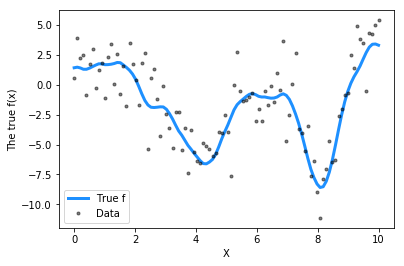

In [10]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
plt.xlabel("X"); plt.ylabel("The true f(x)"); plt.legend();

The data above shows the observations, marked with black dots, of the unknown function $f(x)$ that has been corrupted by some IID normal noise.  The true function is in blue.  

## Coding the model in PyMC3

Here's the model in PyMC3.  We use a $\text{Gamma}(2, 1)$ prior over the lengthscale parameter, and weakly informative $\text{HalfCauchy}(5)$ priors over the covariance function scale, and noise scale.  Then, a GP prior is placed on the unknown function.  For more information on choosing priors in Gaussian process models, check out some of [recommendations by the Stan folks](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations).

In [3]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f", n_points=n, X=X)
    
    σ = pm.HalfCauchy("σ", beta=5)
    y_ = pm.Normal("y", mu=f, sd=σ, observed=y)
    
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 261.21:   9%|▊         | 17287/200000 [00:54<11:42, 260.06it/s]
Convergence archived at 17300
Interrupted at 17,300 [8%]: Average Loss = 294.23
100%|██████████| 1500/1500 [03:29<00:00,  7.72it/s]/home/bill/pymc3/pymc3/step_methods/hmc/nuts.py:463: UserWarning: Chain 0 contains 14 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



## Results

Below are the posteriors of the covariance function hyperparameters.  The red lines show the true values that were used to draw the function from the GP.

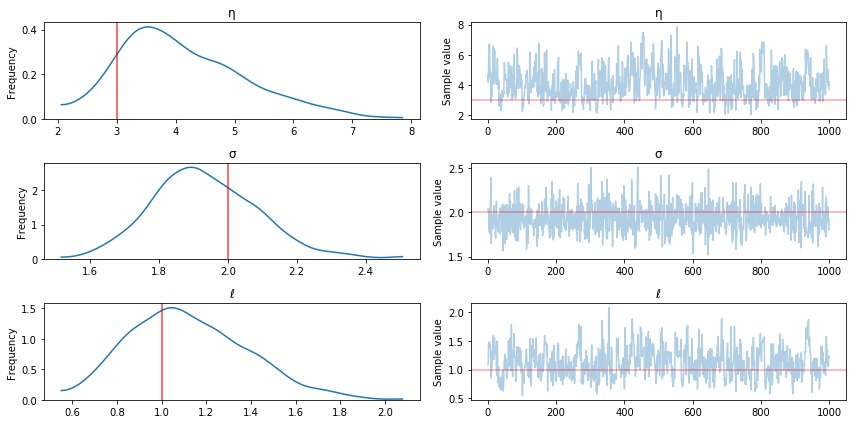

In [4]:
pm.traceplot(trace, lines={"η": η_true, "σ": σ_true, "ℓ": ℓ_true}, varnames=["η", "σ", "ℓ"]);

NameError: name 'trace' is not defined

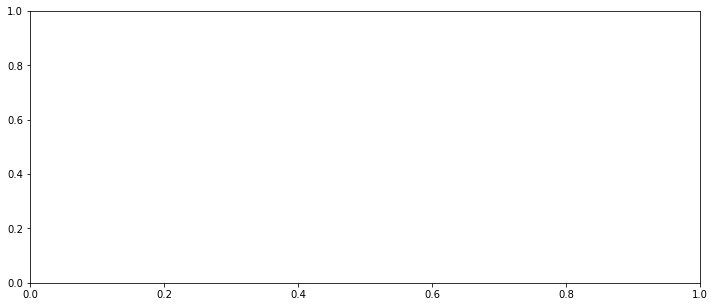

In [15]:
def plot_gp(ax, x, samples, plot_samples=True, palette="Reds"):
    """ a helper function for plotting the gps"""
    cmap = plt.get_cmap(palette)
    percs = np.linspace(51, 99, 20)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(samples, p, axis=1)
        lower = np.percentile(samples, 100-p, axis=1)
        color_val = colors[i]
        ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=0.8)
    if plot_samples:
        # plot a few samples
        idx = np.random.randint(0, samples.shape[1], 30)
        ax.plot(x, samples[:,idx], color=cmap(0.9), lw=1, alpha=0.1)

# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp(ax, X.flatten(), trace["f"].T);
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)"); 
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

As you can see by the red shading, the posterior of the GP prior over the function does a great job of representing both the fit and the uncertainty caused by the additive noise. 

## Prediction

Next, we extend the model by adding the conditional distribution so we can predict at new $x$ locations.  Lets see how the extrapolation out to higher $x$ looks.  To do this, we extend our `model` with the `conditional` distribution of the GP.  Then, we can sample from it using our `trace` and the `sample_ppc` function.  This is similar to how Stan uses its `generated quantities {...}` blocks.

In [6]:
# 200 new values from x=0 to x=20
n_new = 200
X_new = np.linspace(0, 20, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", n_new, X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_ppc(trace, vars=[f_pred], samples=2000)

100%|██████████| 2000/2000 [00:29<00:00, 68.18it/s]


NameError: name 'plot_gp' is not defined

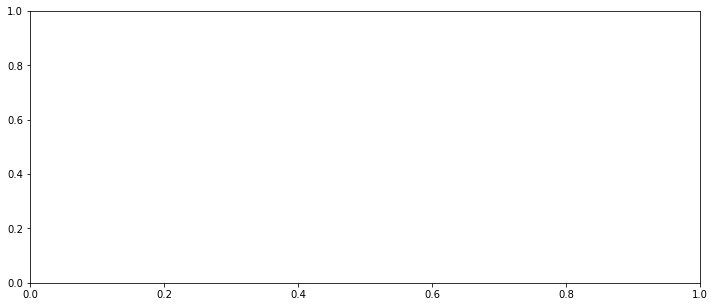

In [4]:
# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp(ax, X_new.flatten(), pred_samples["f_pred"].T);
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)"); plt.ylim([-13,13]);
plt.title("Conditional distribution of f_*, given f"); plt.legend();


#### `gp.Marginal`

Commonly, a function is observed with additive Gaussian noise.  Since multivariate normals are self-conjugate, we can marginalize out the latent function $f(x)$.  Calling the `marginal_likelihood` method creates a PyMC3 random variable that represents 
  $$
    p(y \mid x) = \int p(y \mid f) \, p(f \mid X) df  \,.
  $$ 
  Calling `conditional` produces $\mathbf{f_*}$ (or optionally $\mathbf{y}_*)$, which includes the Gaussian noise).  Since $f(x)$ has been marginalized out, a `prior` method doesn't make sense and is not implemented for `gp.Marginal`.  
  
Similarly to `gp.Latent`, a marginal GP is specified by
  
    gp = pm.gp.Marginal(mean_func, cov_func)
  
  The marginal likelihood, $p(y \mid X)$ is 
  
    ym = gp.marginal_likelihood("ym", n_points, X, y, noise)
    
  the conditional distribution is
  
    f_pred = gp.conditional("f_pred", n_pred, X_new)
  
  
Any number of `gp.*` objects can also be added together using the `+` operator, i.e., `gp3 = gp1 + gp2` (the sum of two GPs is also a GP).  This allows the users to construct composite GP priors for functions that are themselves sums of functions.  Consider the function $f(x_1, x_2) = g(x_1) + h(x_2)$.  By placing GP priors on $g(x_1)$ and $h(x_2)$, we can separate the effects due to $x_1$ and $x_2$ on $f$.  


# Example: `gp.Marginal`

There is a more efficient way to model the last example.  Most GP introductions or tutorials describe the scenario we just covered -- regression with IID Gaussian noise.  This is the most common GP model that people use, but it's really a special case.  When the noise is Gaussian there is no need to explicitly include $\mathbf{f}_x$ as latent variables because it can be integrated out analytically.  

As mentioned before, the product of the GP prior probability distribution with a normal likelihood is also normal.  It's called the *marginal likelihood*.  If we including the prior on the hyperparameters of the covariance function, we can write the *marginal posterior* as

$$
p(y \mid x, \theta)p(\theta) = \int p(y \mid f, x, \theta) \, p(f \mid x, \theta) \,
                                    p(\theta) df
$$

Taking the log,

$$
\log p(y \mid x, \theta) \, p(\theta) = 
  -\frac{1}{2} \mathbf{y}^{T} (K_{xx} + \sigma^2 I)^{-1} \mathbf{y}
  - \frac{1}{2}|K_{xx} + \sigma^2 I|
  - \frac{n}{2}\log (2 \pi) + \log p(\theta)
$$

The first term penalizes lack of fit, the second term penalizes model complexity via the determinant of $K_{xx}$.  The third term is just a constant.  The final term on the right is the log-prior of the covariance function hyperparameters.    

The code to specify this equivalent model using `gp.Marginal` is a little bit different that before.  The `gp.marginal_likelihood` subsumes both the GP prior and the Normal likelihood of the observed data, `y`.  Also, since we are using the marginal likelihood, it is possible to use `find_MAP` to quickly get the value at the mode of the covariance function hyperparameters.  

In [21]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)
     
    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", n_points=n, X=X, y=y, noise=σ)
    
    mp = pm.find_MAP()#method="L-BFGS-B")

Optimization terminated successfully.
         Current function value: 229.664688
         Iterations: 10
         Function evaluations: 14
         Gradient evaluations: 14


In [22]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["ℓ", "η", "σ"], 
              "Value at MAP": [float(mp["ℓ"]), float(mp["η"]), float(mp["σ"])],
              "True value": [ℓ_true, η_true, σ_true]})

KeyError: 'ℓ'

These results closely match the plot of the trace in the `gp.Latent` example!  And also like the last example, we call `conditional` to predict the function $f$ at new `x` locations. 

In [23]:
# new values from x=0 to x=20
n_new = 500
X_new = np.sort(np.random.rand(n_new, 1), 0)
X_new = np.linspace(0, 20, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", n_new, X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_ppc([mp], vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [01:18<00:00, 13.20it/s]


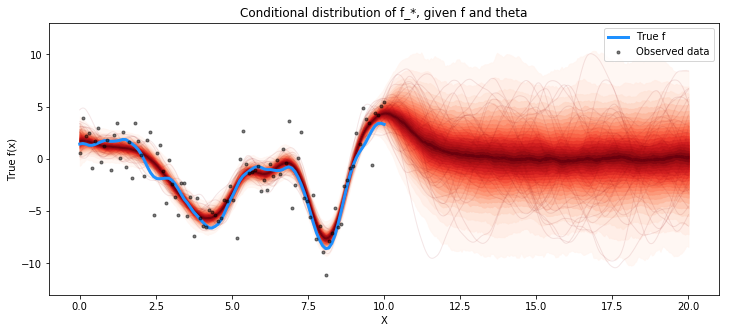

In [24]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp(ax, X_new.flatten(), pred_samples["f_pred"].T);
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("True f(x)"); plt.ylim([-13,13]); 
plt.title("Conditional distribution of f_*, given f and theta"); plt.legend();

The prediction also matches the results from `gp.Latent` very closely.  What about predicting new data points?  Here we only predicted $f_*$, not $f_*$ + noise, which is what we actually observe.

The `conditional` method of `gp.Marginal` contains the flag `pred_noise` whose default value is `False`.  To draw from the *posterior predictive* distribution, we simply set this flag to `True`. 

In [25]:
with model:
    y_pred = gp.conditional("y_pred", n_new, X_new, pred_noise=True)
    y_samples = pm.sample_ppc([mp], vars=[y_pred], samples=1000)

100%|██████████| 1000/1000 [01:25<00:00, 13.48it/s]


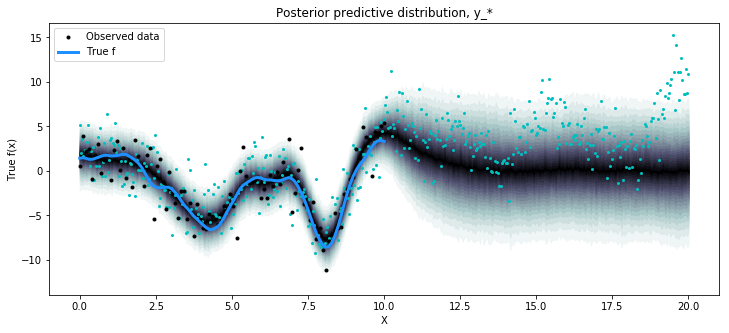

In [26]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp(ax, X_new.flatten(), y_samples["y_pred"].T, False, "bone_r");

"""INSTEAD PLOT 1 SAMPLE FROM PP DIST AS DOTS"""
# overlay a scatter of random points from the posterior predictive distribution
plt.plot(X_new, y_samples["y_pred"][12, :].T, "co", ms=2);

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="Observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");

plt.xlabel("X"); plt.ylabel("True f(x)"); 
plt.title("Posterior predictive distribution, y_*"); plt.legend();

Notice that the posterior predictive density and speckling of samples is wider than the conditional distribution of the noiseless function, and reflects the actual distribution of the data, which is marked as black dots.  